In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [24]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd


In [4]:
PATH = "data/whales/"

In [5]:
sz=224
arch=resnet34

In [6]:
os.listdir(PATH)

['tmp',
 'train.zip',
 'sample_submission.csv',
 'models',
 'train',
 'test.zip',
 'test',
 'train.csv']

In [7]:
data = ImageClassifierData.from_csv(f'{PATH}', folder='train', csv_fname=f'{PATH}train.csv', tfms=tfms_from_model(arch, sz))

Lets look at what our class data actually looks like..

In [8]:
data.classes[:4]

['new_whale', 'w_0013924', 'w_001ebbc', 'w_002222a']

In [9]:
len(data.classes)

4251

This will be just a bunch of whale ids. 4251 of them!

Lets see what our data looks like before we begin.

In [10]:
files = os.listdir(f'{PATH}train')[:5]
ims = [plt.imread(f'{PATH}train/{file}') for file in files]

In [11]:
ims[0].shape

(401, 1050, 3)

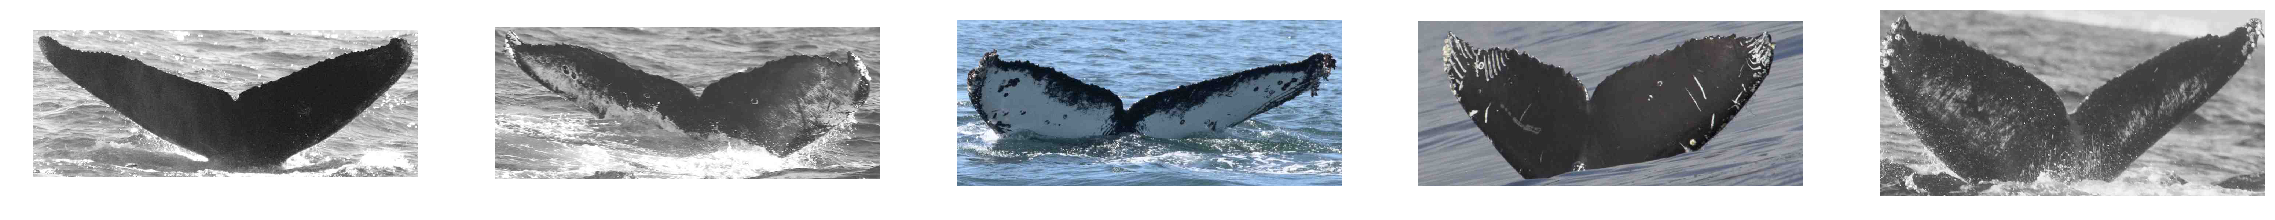

In [12]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(f'Whale', fontsize=12)
        plt.imshow(ims[i]);
        
plots(ims,(40,30))

Looks simple enough! Lets dive in ;)

We will start with a simple precomputed model to see if we stand a chance.

In [13]:
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [14]:
arch=resnet34
sz=299
bs=64
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
# data = ImageClassifierData.from_csv(f'{PATH}', folder='train', csv_fname=f'{PATH}train.csv', tfms=tfms, bs=bs)
# learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(0.01, 1)

In [15]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [16]:
def get_data(sz):
    tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                                        val_idxs=val_idxs, test_name='test')

In [17]:
data = get_data(299)

In [18]:
x,y = next(iter(data.val_dl))

In [19]:
f_model = resnet34
learn = ConvLearner.pretrained(f_model, data)

 93%|█████████▎| 115/124 [02:53<00:13,  1.51s/it, loss=155] 

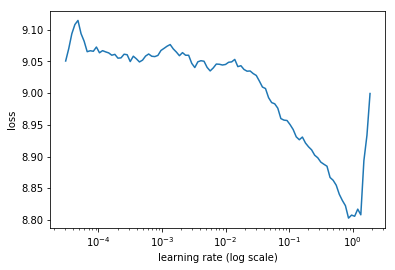

In [20]:
lrf=learn.lr_find()
learn.sched.plot()

In [21]:
learn.fit(0.5, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/124 [00:00<?, ?it/s]                    


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:70

In [33]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{PATH}/train/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(20, 12))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')

In [30]:
train_df = pd.read_csv(f'{PATH}train.csv')
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


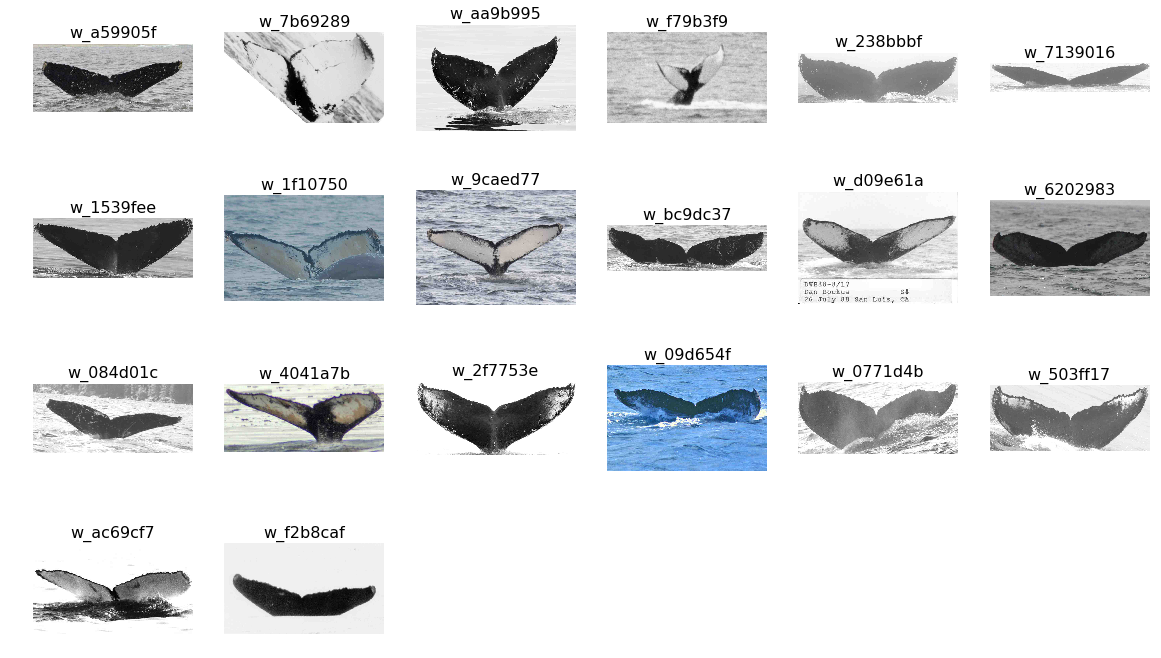

In [34]:
rand_rows = train_df.sample(frac=1.)[:20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

In [35]:
size_buckets = Counter(train_df['Id'].value_counts().values)

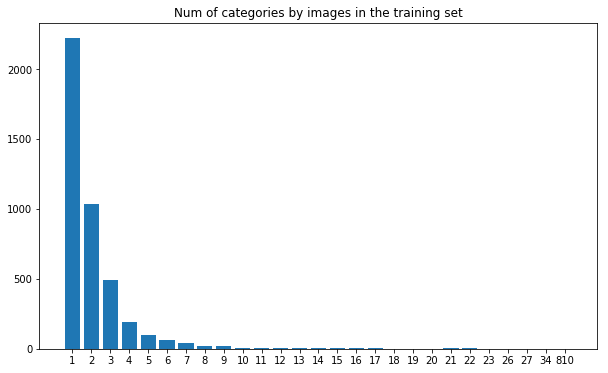

In [36]:
plt.figure(figsize=(10, 6))

plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")

plt.show()

In [39]:
len(train_df)

9850